In [1]:
import pymaster as nmt
import numpy as np
import healpy as hp
import wget
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d

These notebooks aim to provide a comprehensive review of the functionality implemented in NaMaster. No rigorous mathematical derivations of any statements made will be provided, and users are referred to the references below for further details:
- **A19**. The original NaMaster paper (Alonso et al. 2019 https://arxiv.org/abs/1809.09603).
- **G19**. Garcia-Garcia et al. 2019 (https://arxiv.org/abs/1906.11765), which introduces the basic approximation used by NaMaster to estimate covariance matrix.
- **N20**. Nicola et al. 2020 (https://arxiv.org/abs/2010.09717), which refined these approximations and described in detail the procedure to estimate cosmic shear power spectra.
- **W24**. Wolz et al. 2024 (https://arxiv.org/abs/2407.21013), which introduced the formalism for catalog-based $C_\ell$s.
- **A24**. Alonso 2024 (https://arxiv.org/abs/2410.07077), which generalised the estimator to anisotropic weights.

# 4 Catalog-based power spectra <a class="anchor" id="S4"></a>
This tutorial presents the infrastructure built in NaMaster for the calculation of power spectra of fields defined at (or from) the positions of a discrete set of sources. The methodology is described in detail in W24. This builds on the work of [Baleato & White 2024](https://arxiv.org/abs/2312.12285).

The code below demonstrates the use of this methodology for a realistic galaxy catalog, in the context of spin-0 and spin-2 fields (similar to the case of cosmic shear catalogs), and in the context of galaxy clustering, where the overdensity of sources themselves is the field of interest.

# Table of contents

* [4.1 Catalog-based fields](#Ss4.1)
* [4.2 Unbiased estimator](#Ss4.2)
* [4.3 Clustering](#Ss4.3)
* [4.4 Combining catalog-based and normal fields](#Ss4.4)

## 4.1 Catalog-based fields <a class="anchor" id="Ss4.1"></a>
In their most general form, catalog-based fields are fields with values only defined at the angular positions of a discrete set of sources. These fields are then defined by the angular coordinates of the sources, the corresponding measured field values and, additionally, the source weights, which may be used, for instance, to optimally combine measurements from sources with varying signal-to-noise ratios.

Below we show how to construct a standard catalog-based field. We will use the positions of sources in a real catalog: the Quaia quasar sample of [Storey-Fisher et al. 2023](https://arxiv.org/abs/2306.17749), [Alonso et al. 2023](https://arxiv.org/abs/2306.17748). We first start by downloading the catalog and its angular selection function. For our discussion of clustering, in [Section 4.3](#Ss4.3), we will need a random catalog for this sample, so we will construct it here too from the selection function.

In [2]:
# Download and read selection function
fname_sel = 'selection_function_NSIDE64_G20.5_zsplit2bin0.fits'
if not os.path.isfile(fname_sel):
    wget.download("https://zenodo.org/records/8098636/files/selection_function_NSIDE64_G20.5_zsplit2bin0.fits?download=1")
sel = hp.read_map(fname_sel)

# Download and read catalog
fname_cat = 'quaia_G20.5.fits'
if not os.path.isfile(fname_cat):
    wget.download("https://zenodo.org/records/10403370/files/quaia_G20.5.fits?download=1")
cat = fits.open(fname_cat)[1].data
# Select only sources with redshifts z < 1.47 (first bin of Alonso et al. 2023)
cat = cat[cat['redshift_quaia'] < 1.47]
nsrc = len(cat)
print(f"The catalog has {nsrc} sources.")

# Since we will need them for clustering, let us also generate a random catalog
nran = 50*nsrc
nside_sel = hp.npix2nside(len(sel))
th_ran = np.arccos(-1+2*np.random.rand(nran))
phi_ran = 2*np.pi*np.random.rand(nran)
u_ran = np.random.rand(nran)
ipix_ran = hp.ang2pix(nside_sel, th_ran, phi_ran)
keep = u_ran <= sel[ipix_ran]
nran = np.sum(keep)
print(f"Random catalog has {nran} sources")
# Assign RA, Dec, and weights
pos_ran = np.array([np.degrees(phi_ran[keep]), 90-np.degrees(th_ran[keep])])
w_ran = np.ones(nran)
ipix_ran = ipix_ran[keep]

The catalog has 644786 sources.
Random catalog has 22390184 sources


Having read the catalog, let's assign each source a weight (we will use equal unit weights for simplicity) and field values. For the latter, we will generate a Gaussian realisation of a continuous field from a known power spectrum at a high resolution, and simply assign the value of that field at the pixel occupied by each source. We use a simple power spectrum of the form $C_\ell=1/(\ell+10)$. The corresponding field is arbitrary. Use your imagination and pretend it's the value of e.g. the lensing convergence at the source's position (perhaps estimated from the source's size), or the value of the integrated electron density, if these sources were FRBs.

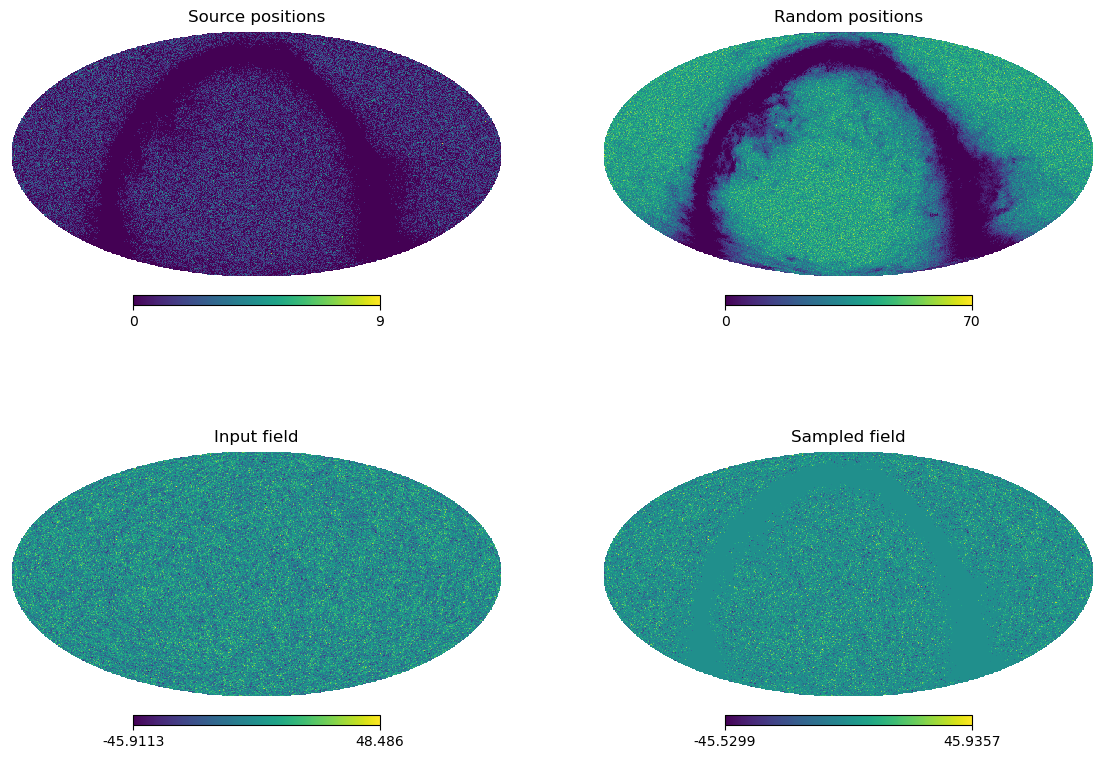

In [3]:
nside = 256
npix = hp.nside2npix(nside)
lmax = 3*nside-1
lmax_nside = 3*nside-1
ls = np.arange(lmax_nside+1)
pixwin = hp.pixwin(nside)
cl_true = 1/(ls+10)

# Simulator
def gen_sim(spin=0):
    if spin == 0:
        mp = hp.synfast(cl_true, nside)
    else:
        almE = hp.synalm(cl_true)
        almB = almE*0
        mp = np.array(hp.alm2map_spin([almE, almB], nside,
                                      spin, lmax_nside))
    return mp

# Catalog positions
pos_data = np.array([cat['ra'], cat['dec']])

# Catalog weights
w_data = np.ones(nsrc)

# Generate continuous map
mp = gen_sim()
# Calculate pixel indices for each souce
ipix = hp.ang2pix(nside, pos_data[0], pos_data[1], lonlat=True)
# Assign field values from sky positions
fval = mp[ipix]

# Plot the source distribution and the field values, so we get an
# idea of what the data looks like
nc_data = np.bincount(ipix, minlength=npix)
nc_ran = np.bincount(hp.ang2pix(nside, pos_ran[0], pos_ran[1], lonlat=True),
                     minlength=npix)
mp_cat = np.bincount(ipix, minlength=npix, weights=fval)
mp_cat[nc_data > 0] = mp_cat[nc_data > 0] / nc_data[nc_data > 0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.axes(axes[0][0])
hp.mollview(nc_data, title='Source positions', hold=True)
plt.axes(axes[0][1])
hp.mollview(nc_ran, title='Random positions', hold=True)
plt.axes(axes[1][0])
hp.mollview(mp, title='Input field', hold=True)
plt.axes(axes[1][1])
hp.mollview(mp_cat, title='Sampled field', hold=True)

OK, now that we have all the data, this is how you create a `NmtFieldCatalog` object:

In [4]:
fld = nmt.NmtFieldCatalog(pos_data, w_data, fval, lmax=lmax_nside, lonlat=True)

You can then use this field to compute power spectra the same way you would for normal NaMaster fields.

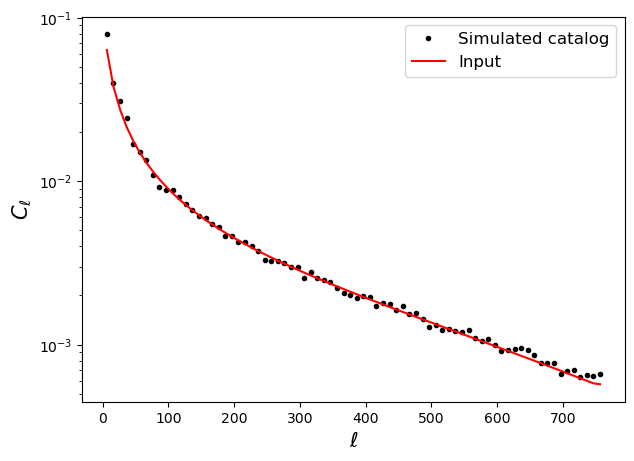

In [5]:
b = nmt.NmtBin.from_lmax_linear(lmax, nlb=10)
w = nmt.NmtWorkspace.from_fields(fld, fld, b)
pcl = nmt.compute_coupled_cell(fld, fld)
cl = w.decouple_cell(pcl)

leff = b.get_effective_ells()
plt.figure(figsize=(7, 5))
plt.plot(leff, cl[0], 'k.', label='Simulated catalog')
# Note that we need to correct the input power spectrum for the pixel window
# function we used to generate the simulation.
cl_pred = w.decouple_cell(w.couple_cell([cl_true*pixwin**2]))
plt.plot(leff, cl_pred[0], 'r-', label='Input')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=12);

One of the neat things about the catalog-based pseudo-$C_\ell$ method implemented in NaMaster is that, as described in W24, the estimator is immune to any form of uncorrelated noise between sources. We can show this explicitly here by adding some amount of noise to each source and recomputing the power spectrum.

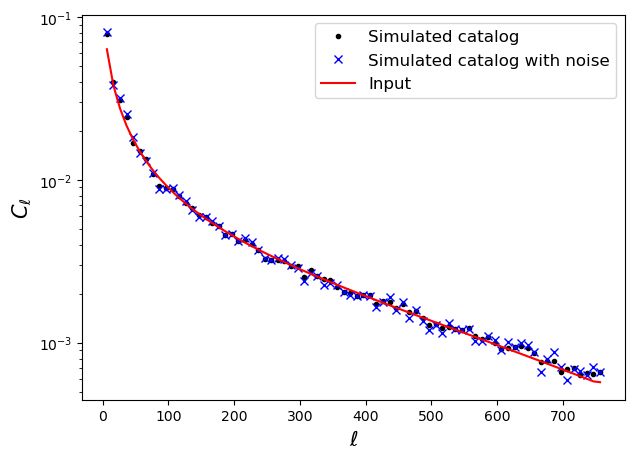

In [6]:
# Compute the std of the real field, and add the same
# amount in uncorrelated noise.
sigma = np.std(fval)
nval = np.random.randn(nsrc) * sigma

fld_n = nmt.NmtFieldCatalog(pos_data, w_data, fval+nval,
                            lmax=lmax, lmax_mask=4*lmax, lonlat=True)
pcl_n = nmt.compute_coupled_cell(fld_n, fld_n)
cl_n = w.decouple_cell(pcl_n)

plt.figure(figsize=(7, 5))
plt.plot(leff, cl[0], 'k.', label='Simulated catalog')
plt.plot(leff, cl_n[0], 'bx', label='Simulated catalog with noise')
# Note that we need to correct the input power spectrum for the pixel window
# function we used to generate the simulation.
cl_pred = w.decouple_cell(w.couple_cell([cl_true*pixwin**2]))
plt.plot(leff, cl_pred[0], 'r-', label='Input')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=12);

## 4.2 Unbiased estimator <a class="anchor" id="Ss4.2"></a>
OK, with this at hand, let's now show that the catalog method is unbiased. We'll do it first for spin-0 fields as simulated above, and then for spin-2 fields (more akin to what a cosmic shear analysis would be like).

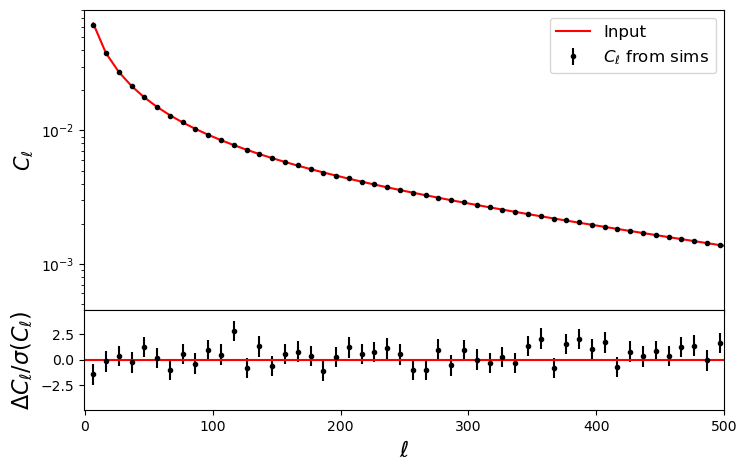

In [7]:
# Code to generate simulated fields
def gen_catalog_field(spin=0, with_noise=False, return_map=False):
    mp = np.atleast_2d(gen_sim(spin=spin))
    fval = mp[:, ipix]
    if with_noise:
        nval = np.random.randn(*(fval.shape)) * sigma
        fval += nval
    fld = nmt.NmtFieldCatalog(pos_data, w_data, fval, spin=spin,
                              lmax=lmax, lonlat=True)
    if return_map:
        return fld, mp
    return fld

nsims = 100
cls = []
for i in range(nsims):
    fld = gen_catalog_field()
    cls.append(w.decouple_cell(nmt.compute_coupled_cell(fld, fld)))
cls = np.array(cls)

# Mean
cl_mean = np.mean(cls, axis=0)
# Uncertainty
cl_error = np.std(cls, axis=0)/np.sqrt(nsims)

# Plot comparison
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes((.1,.3,.8,.6))
ax.plot(leff, cl_pred[0], 'r-', label='Input')
ax.errorbar(leff, cl_mean[0], yerr=cl_error[0], fmt='k.', label=r'$C_\ell$ from sims')
ax.set_yscale('log')
ax.set_ylabel(r'$C_\ell$', fontsize=15)
ax.set_xticklabels([])
ax.set_xlim([-0.5, 500])
ax.legend(fontsize=12)

ax = fig.add_axes((.1,.1,.8,.2))
ax.errorbar(leff, ((cl_mean-cl_pred)/cl_error)[0], yerr=np.ones_like(leff), fmt='k.')
ax.axhline(0, c='r', ls='-')
ax.set_ylim([-4.9, 4.9])
ax.set_xlim([-0.5, 500])
ax.set_ylabel(r'$\Delta C_\ell/\sigma(C_\ell)$', fontsize=16)
ax.set_xlabel(r'$\ell$', fontsize=16);

Great! Now let's repeat this for a spin-2 field.

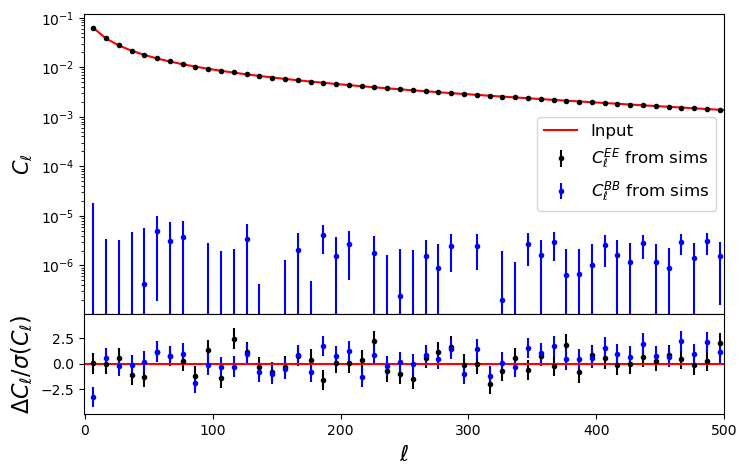

In [8]:
# First we need to calculate the corresponding MCM for spin-2
f2 = nmt.NmtFieldCatalog(pos_data, w_data, None, spin=2,
                         lmax=lmax, lonlat=True)
w2 = nmt.NmtWorkspace.from_fields(f2, f2, b)
# ... and the corresponding theory prediction
cl_pred2 = w2.decouple_cell(w2.couple_cell([cl_true*hp.pixwin(nside)**2,
                                            0*cl_true, 0*cl_true, 0*cl_true]))


cls = []
for i in range(nsims):
    fld = gen_catalog_field(spin=2)
    cls.append(w2.decouple_cell(nmt.compute_coupled_cell(fld, fld)))
cls = np.array(cls)

# Mean
cl_mean = np.mean(cls, axis=0)
# Uncertainty
cl_error = np.std(cls, axis=0)/np.sqrt(nsims)

# Plot comparison
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes((.1,.3,.8,.6))
ax.plot(leff, cl_pred2[0], 'r-', label='Input')
ax.errorbar(leff, cl_mean[0], yerr=cl_error[0], fmt='k.', label=r'$C^{EE}_\ell$ from sims')
ax.errorbar(leff, cl_mean[3], yerr=cl_error[3], fmt='b.', label=r'$C^{BB}_\ell$ from sims')
ax.set_yscale('log')
ax.set_ylabel(r'$C_\ell$', fontsize=15)
ax.set_xticklabels([])
ax.set_xlim([-0.5, 500])
ax.legend(fontsize=12)

ax = fig.add_axes((.1,.1,.8,.2))
ax.errorbar(leff, ((cl_mean-cl_pred2)/cl_error)[0], yerr=np.ones_like(leff), fmt='k.')
ax.errorbar(leff, ((cl_mean-cl_pred2)/cl_error)[3], yerr=np.ones_like(leff), fmt='b.')
ax.axhline(0, c='r', ls='-')
ax.set_ylim([-4.9, 4.9])
ax.set_xlim([-0.5, 500])
ax.set_ylabel(r'$\Delta C_\ell/\sigma(C_\ell)$', fontsize=16)
ax.set_xlabel(r'$\ell$', fontsize=16);

## 4.3 Clustering <a class="anchor" id="Ss4.3"></a>
Now let us explore the clustering. In this case, the overdensity of catalog sources is itself the field of interest (rather than a field sampled at the source positions). It is also common for the completeness of the survey (i.e. the spatial variations in the mean number of density of sources that should be observed at a given sky position in the absence of astrophysical anisotropies) to be characterised by the positions of a "random" catalog, composed of a set of unclustered sources (in general with their own weights).

We created a random catalog for our sample back in [Section 4.1](#Ss4.1). The code below shows how to use this random catalog to extract the clustering power spectrum of our sample, and compares the result with the standard pixelised approach.

### 4.3.1 The standard pixelised approach
Before we get to the catalog-based method, let's demonstrate the standard pixel-based procedure. We start by creating a map $N_p$ containing the number of sources in each pixel $p$. We then compare this with a map $\bar{N}_p$ containing the weighted number of expected sources in each pixel (which we construct from the selection function) from the selection function, and estimate the overdensity map:
$$
  \delta_p =\frac{N_p}{\bar{N}_p}-1
$$
The $\bar{N}_p$ is given by $\bar{N}_p = \bar{N}\,w_p$, where $w_p$ is the selection, and $\bar{N}\equiv\sum_p N_p/\sum_p w_p$. Finally, assuming Poisson-distributed objects, the selection function itself is a reasonable mask choice (since it's proportional to the inverse variance of the field, $w_p\propto\bar{N}_p$).

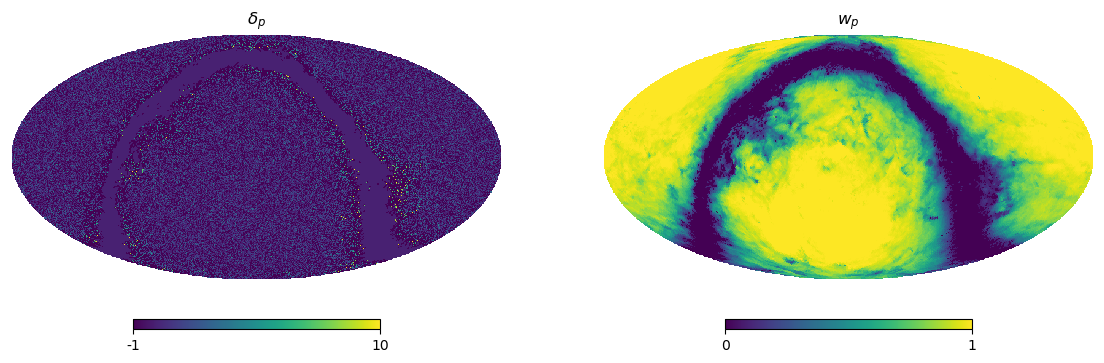

In [9]:
nmap = np.bincount(ipix, minlength=npix, weights=w_data)
mask = hp.ud_grade(sel, nside_out=nside)
nbar = np.sum(nmap)/np.sum(mask)
nbar_map = nbar * mask
# Avoid division by zero below
good = mask > 0
delta = np.zeros(npix)
delta[good] = nmap[good]/nbar_map[good]-1

# Now create a NaMaster field
f_pix = nmt.NmtField(mask, [delta], n_iter=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 10))
plt.axes(axes[0])
hp.mollview(delta, title=r'$\delta_p$', hold=True, max=10)
plt.axes(axes[1])
hp.mollview(sel, title='$w_p$', hold=True)

Note that, above, you can definitely still see some contamination close to the Galactic plane. In [Alonso et al. 2023](https://arxiv.org/abs/2306.17748) this was avoided by removing all pixels where the selection function was $w_p<0.5$, but we won't do this here for simplicity.

OK, now we can compute the power spectrum, but we must also compute the associated noise bias due to shot noise. Assuming Poisson statistics, the pseudo-$C_\ell$ of this noise bias is simply given by
$$
  \tilde{N}_\ell = \Omega_{\rm pix}\,\frac{\langle w\rangle_{\rm pix}}{\bar{N}},
$$
where $\langle\cdots\rangle$ denotes averaging over all sky pixels.

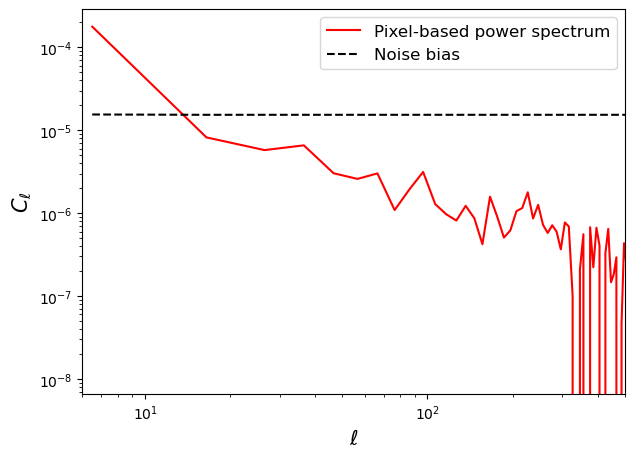

In [10]:
# Compute the mode-coupling matrix
wpix = nmt.NmtWorkspace.from_fields(f_pix, f_pix, b)

pcl = nmt.compute_coupled_cell(f_pix, f_pix)
cl = wpix.decouple_cell(pcl)

pnl = 4*np.pi*np.mean(mask)/(npix*nbar)
nl = wpix.decouple_cell(pnl*np.ones_like(pcl))

cl_pix = cl-nl

plt.figure(figsize=(7, 5))
plt.plot(leff, cl_pix[0], 'r-', label='Pixel-based power spectrum')
plt.plot(leff, nl[0], 'k--', label='Noise bias')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.xlim([6, 500])
plt.legend(fontsize=12);

### 4.3.2 The catalog-based method
Now let's use the catalog-based method. In the case of clustering data, this is handled in NaMaster via the `NmtFieldCatalogClustering` object, which accepts positions and weights for both the data and random catalogs. The resuling noise bias is estimated analytically and subtracted, so you don't even need to bother with it.

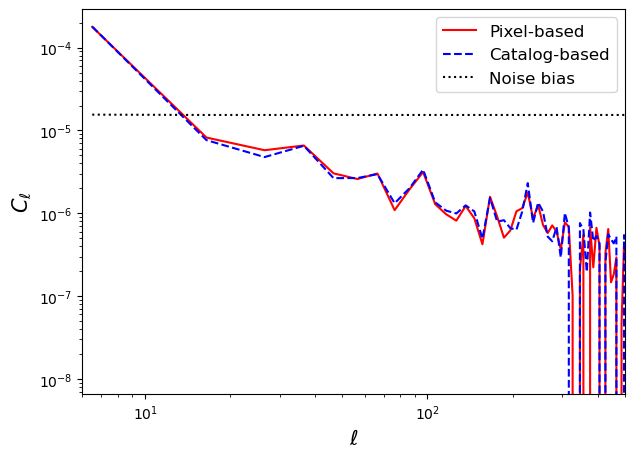

In [11]:
f_cat = nmt.NmtFieldCatalogClustering(pos_data, w_data, pos_ran, w_ran, lmax=lmax, lonlat=True)
w_cat = nmt.NmtWorkspace.from_fields(f_cat, f_cat, b)

pcl = nmt.compute_coupled_cell(f_cat, f_cat)
cl_cat = w_cat.decouple_cell(pcl)

plt.figure(figsize=(7, 5))
plt.plot(leff, cl_pix[0], 'r-', label='Pixel-based')
plt.plot(leff, cl_cat[0], 'b--', label='Catalog-based')
plt.plot(leff, nl[0], 'k:', label='Noise bias')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.xlim([6, 500])
plt.legend(fontsize=12);

## 4.4 Combining catalog-based and normal fields <a class="anchor" id="Ss4.4"></a>
Catalog-based and map-based fields can be combined seamlessly to compute power spectra. Just treat catalog-based fields the same way you would normal ones! There are certain things you will not be able to do with catalog-based fields, such as querying their maps and masks or, unfortunately, computing covariance matrices (although we hope to add functionality for the latter soon).

The code below shows what you can and cannot do with catalog-based fields.

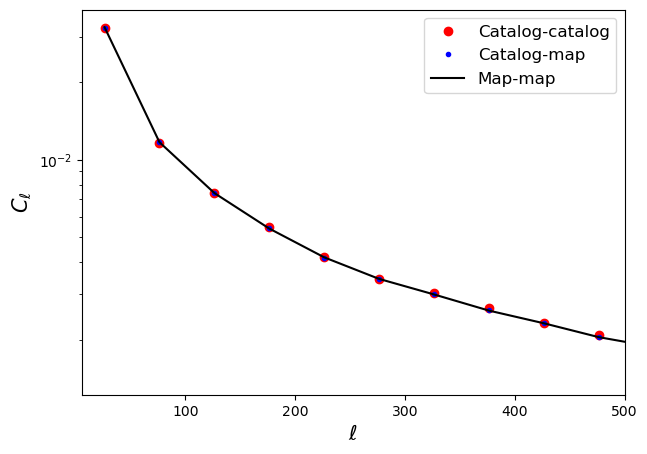

In [12]:
# Let's create a catalog-based field and, from it,
# a map-based field representing the same full-sky
# map.
b = nmt.NmtBin.from_lmax_linear(lmax, nlb=50)
leff = b.get_effective_ells()
f_cat, mp = gen_catalog_field(return_map=True)
mp[:, mask == 0] = 0
f_pix = nmt.NmtField(mask, mp, n_iter=0)

# You can compute both the auto and cross-correlations of both fields:
def get_cl(f1, f2):
    w = nmt.NmtWorkspace.from_fields(f1, f2, b)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f1, f2))
    return cl

cl_cc = get_cl(f_cat, f_cat)
cl_cp = get_cl(f_cat, f_pix)
cl_pp = get_cl(f_pix, f_pix)

# Note that, because we simulate catalogs from a pixelised
# map, we need to account for that pixel window function.
# We do so in a slightly ad-hoc manner here.
pixwin = interp1d(np.arange(lmax_nside+1), hp.pixwin(nside))(leff)
cl_cp /= pixwin
cl_cc /= pixwin**2

plt.figure(figsize=(7, 5))
plt.plot(leff, cl_cc[0], 'ro', label='Catalog-catalog')
plt.plot(leff, cl_cp[0], 'b.', label='Catalog-map')
plt.plot(leff, cl_pp[0], 'k-', label='Map-map')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.xlim([6, 500])
plt.legend(fontsize=12);

However, you cannot query maps or masks

In [13]:
f_cat.get_maps()

ValueError: Input maps unavailable for this field

In [14]:
print(f_cat.get_mask())

ValueError: Input mask unavailable for this field

or compute covariances

In [15]:
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f_cat, f_cat)

ValueError: Input mask unavailable for this field